<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\twoli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [4]:
# Загрузим датасет
dataset = load_dataset('imdb')

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [5]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for split in ['train', 'test']:
    for example in dataset[split]:
        text = example['text']
        # Разделяем на предложения
        sents = sent_tokenize(text)
        for sent in sents:
            # Токенизируем предложение и проверяем длину
            words = word_tokenize(sent)
            if len(words) < word_threshold:
                sentences.append(sent)

In [6]:
print("Всего предложений:", len(sentences))

sentences

Всего предложений: 392752


['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967.',
 "Really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno.",
 'While my countrymen mind find it shocking, in reality sex and nudity are a major staple in Swedish cinema.',
 'I AM CURIOUS-YELLOW is a good film for anyone wanting to study the meat and potatoes (no pun intended) of Swedish cinema.',
 "But really, this film doesn't have much of a plot.",
 '"I Am Curious: Yellow" is a risible and pretentious steaming pile.',
 "It doesn't matter what one's political views are because this film can hardly be taken seriously on any level.",
 "As for the claim that frontal male nudity is an automatic NC-17, that isn't true.",
 "I've seen R-rated films with male nudity.",
 'Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia?',
 "Nowhere, be

Посчитаем для каждого слова его встречаемость.

In [7]:
words = Counter()

# Расчет встречаемости слов
for sentence in sentences:
    tokenized_words = word_tokenize(sentence)
    words.update(tokenized_words)

words

Counter({'I': 93840,
         'rented': 449,
         'AM': 27,
         'CURIOUS-YELLOW': 2,
         'from': 16661,
         'my': 11315,
         'video': 1573,
         'store': 525,
         'because': 7210,
         'of': 123513,
         'all': 19998,
         'the': 251333,
         'controversy': 52,
         'that': 61860,
         'surrounded': 96,
         'it': 78621,
         'when': 9990,
         'was': 54710,
         'first': 7457,
         'released': 937,
         'in': 75975,
         '1967': 36,
         '.': 336931,
         'Really': 349,
         ',': 225416,
         'sex': 1386,
         'and': 135801,
         'nudity': 470,
         'scenes': 4795,
         'are': 29380,
         'few': 3626,
         'far': 2657,
         'between': 2753,
         'even': 10319,
         'then': 5905,
         "'s": 57280,
         'not': 28731,
         'shot': 1761,
         'like': 18632,
         'some': 12662,
         'cheaply': 47,
         'made': 7745,
         'p

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [8]:
vocab = set()
vocab_size = 40000

# Наполнение словаря
# Добавляем служебные токены
vocab.add('<unk>')
vocab.add('<bos>')
vocab.add('<eos>')
vocab.add('<pad>')

# Добавляем vocab_size самых частых слов
most_common_words = [word for word, count in words.most_common(vocab_size)]
vocab.update(most_common_words)

In [9]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [10]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [11]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [12]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        
        # Токенизируем предложение
        words = word_tokenize(self.data[idx])
        
        # Преобразуем слова в индексы
        for word in words:
            word_id = word2ind.get(word, self.unk_id)
            tokenized_sentence.append(word_id)
        
        tokenized_sentence.append(self.eos_id)

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [13]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [14]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [15]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [16]:
def train_model(model, train_dataloader, eval_dataloader, num_epochs=10, learning_rate=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    
    train_losses = []
    eval_perplexities = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        # Оценка на валидационном множестве
        eval_perplexity = evaluate(model, criterion, eval_dataloader)
        eval_perplexities.append(eval_perplexity)
        
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Eval Perplexity = {eval_perplexity:.4f}")
    
    return train_losses, eval_perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [19]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2, dropout=0.2):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()
        
    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # Эмбеддинги
        embedded = self.embedding(input_batch)
        
        # LSTM
        lstm_out, _ = self.lstm(embedded)
        
        # Дропаут и линейный слой
        output = self.dropout(lstm_out)
        logits = self.linear(self.non_lin(output))
        
        return logits

In [20]:
# Обучите модель здесь
# Первый эксперимент: Базовая LSTM модель
print("=== Первый эксперимент: Базовая LSTM модель ===")

model1 = LanguageModel(
    vocab_size=len(vocab),
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2,
    dropout=0.2
).to(device)

print(f"Модель создана. Параметров: {sum(p.numel() for p in model1.parameters()):,}")

# Обучаем модель
train_losses1, eval_perplexities1 = train_model(
    model1, train_dataloader, eval_dataloader, 
    num_epochs=15, learning_rate=0.001
)

# Оценка на тестовом множестве
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
test_perplexity1 = evaluate(model1, criterion, test_dataloader)
print(f"Тестовая перплексия модели 1: {test_perplexity1:.4f}")

# Сохраняем результаты
results = {
    'model1': {
        'architecture': 'LSTM (2 layers, 256 hidden, 128 embedding)',
        'test_perplexity': test_perplexity1,
        'train_losses': train_losses1,
        'eval_perplexities': eval_perplexities1
    }
}

=== Первый эксперимент: Базовая LSTM модель ===
Модель создана. Параметров: 16,323,140


Epoch 1/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 1: Train Loss = 5.6766, Eval Perplexity = 155.6546


Epoch 2/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 2: Train Loss = 4.9289, Eval Perplexity = 112.7763


Epoch 3/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 3: Train Loss = 4.7069, Eval Perplexity = 95.1709


Epoch 4/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 4: Train Loss = 4.5727, Eval Perplexity = 84.6974


Epoch 5/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 5: Train Loss = 4.4776, Eval Perplexity = 77.7761


Epoch 6/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 6: Train Loss = 4.4042, Eval Perplexity = 72.7298


Epoch 7/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 7: Train Loss = 4.3461, Eval Perplexity = 69.0153


Epoch 8/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 8: Train Loss = 4.2971, Eval Perplexity = 66.0293


Epoch 9/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 9: Train Loss = 4.2558, Eval Perplexity = 63.7259


Epoch 10/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 10: Train Loss = 4.2204, Eval Perplexity = 61.7164


Epoch 11/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 11: Train Loss = 4.1890, Eval Perplexity = 60.0332


Epoch 12/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 12: Train Loss = 4.1614, Eval Perplexity = 58.5869


Epoch 13/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 13: Train Loss = 4.1363, Eval Perplexity = 57.3716


Epoch 14/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 14: Train Loss = 4.1131, Eval Perplexity = 56.2265


Epoch 15/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 15: Train Loss = 4.0925, Eval Perplexity = 55.1817
Тестовая перплексия модели 1: 55.2198


### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [21]:
# Проведите второй эксперимент
print("\n=== Второй эксперимент: Улучшенная LSTM модель с Layer Normalization ===")

class ImprovedLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512, num_layers=3, dropout=0.3):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Layer Normalization после LSTM
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
        # Двухслойный MLP с активацией
        self.dropout1 = nn.Dropout(dropout)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.dropout2 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(hidden_dim // 2, vocab_size)
        self.activation = nn.ReLU()
        
    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # Эмбеддинги
        embedded = self.embedding(input_batch)
        
        # LSTM
        lstm_out, _ = self.lstm(embedded)
        
        # Layer Normalization
        normalized_out = self.layer_norm(lstm_out)
        
        # Двухслойный MLP с активацией
        output = self.dropout1(normalized_out)
        output = self.linear1(output)
        output = self.activation(output)
        output = self.dropout2(output)
        logits = self.linear2(output)
        
        return logits

# Создаем улучшенную модель
model2 = ImprovedLanguageModel(
    vocab_size=len(vocab),
    embedding_dim=256,
    hidden_dim=512,
    num_layers=3,
    dropout=0.3
).to(device)

print(f"Модель создана. Параметров: {sum(p.numel() for p in model2.parameters()):,}")

# Обучаем модель с другим learning rate
train_losses2, eval_perplexities2 = train_model(
    model2, train_dataloader, eval_dataloader, 
    num_epochs=15, learning_rate=0.001
)

# Оценка на тестовом множестве
test_perplexity2 = evaluate(model2, criterion, test_dataloader)
print(f"Тестовая перплексия модели 2: {test_perplexity2:.4f}")

# Добавляем результаты
results['model2'] = {
    'architecture': 'LSTM (3 layers, 512 hidden, 256 embedding, LayerNorm, 2-layer MLP)',
    'test_perplexity': test_perplexity2,
    'train_losses': train_losses2,
    'eval_perplexities': eval_perplexities2
}


=== Второй эксперимент: Улучшенная LSTM модель с Layer Normalization ===
Модель создана. Параметров: 26,433,860


Epoch 1/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 1: Train Loss = 5.1473, Eval Perplexity = 102.6698


Epoch 2/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 2: Train Loss = 4.6776, Eval Perplexity = 81.9962


Epoch 3/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 3: Train Loss = 4.5183, Eval Perplexity = 72.6645


Epoch 4/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 4: Train Loss = 4.4205, Eval Perplexity = 67.0356


Epoch 5/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 5: Train Loss = 4.3513, Eval Perplexity = 63.2635


Epoch 6/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 6: Train Loss = 4.2969, Eval Perplexity = 60.4431


Epoch 7/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 7: Train Loss = 4.2550, Eval Perplexity = 58.2653


Epoch 8/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 8: Train Loss = 4.2198, Eval Perplexity = 56.4731


Epoch 9/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 9: Train Loss = 4.1899, Eval Perplexity = 55.1064


Epoch 10/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 10: Train Loss = 4.1646, Eval Perplexity = 53.9512


Epoch 11/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 11: Train Loss = 4.1420, Eval Perplexity = 52.8908


Epoch 12/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 12: Train Loss = 4.1230, Eval Perplexity = 52.0263


Epoch 13/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 13: Train Loss = 4.1053, Eval Perplexity = 51.2617


Epoch 14/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 14: Train Loss = 4.0894, Eval Perplexity = 50.5304


Epoch 15/15:   0%|          | 0/2455 [00:00<?, ?it/s]

Epoch 15: Train Loss = 4.0756, Eval Perplexity = 49.9330
Тестовая перплексия модели 2: 50.0074


### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

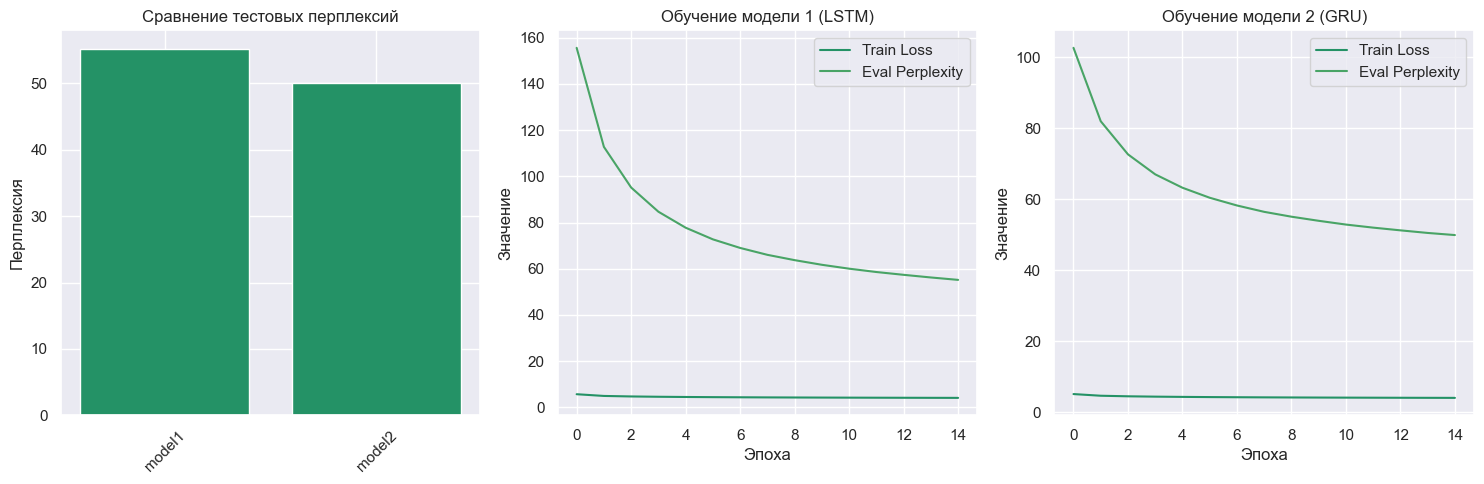


=== ТАБЛИЦА РЕЗУЛЬТАТОВ ===
                     Модель                                                        Архитектура Тестовая перплексия
            Модель 1 (LSTM)                         LSTM (2 layers, 256 hidden, 128 embedding)             55.2198
Модель 2 (LSTM + LayerNorm) LSTM (3 layers, 512 hidden, 256 embedding, LayerNorm, 2-layer MLP)             50.0074


In [22]:
# Визуализация результатов
plt.figure(figsize=(15, 5))

# График 1: Сравнение перплексий
plt.subplot(1, 3, 1)
models = list(results.keys())
perplexities = [results[model]['test_perplexity'] for model in models]
plt.bar(models, perplexities)
plt.title('Сравнение тестовых перплексий')
plt.ylabel('Перплексия')
plt.xticks(rotation=45)

# График 2: Обучение первой модели
plt.subplot(1, 3, 2)
plt.plot(results['model1']['train_losses'], label='Train Loss')
plt.plot(results['model1']['eval_perplexities'], label='Eval Perplexity')
plt.title('Обучение модели 1 (LSTM)')
plt.xlabel('Эпоха')
plt.ylabel('Значение')
plt.legend()

# График 3: Обучение второй модели
plt.subplot(1, 3, 3)
plt.plot(results['model2']['train_losses'], label='Train Loss')
plt.plot(results['model2']['eval_perplexities'], label='Eval Perplexity')
plt.title('Обучение модели 2 (GRU)')
plt.xlabel('Эпоха')
plt.ylabel('Значение')
plt.legend()

plt.tight_layout()
plt.show()

# Создание таблицы результатов
import pandas as pd

results_table = pd.DataFrame({
    'Модель': ['Модель 1 (LSTM)', 'Модель 2 (LSTM + LayerNorm)'],
    'Архитектура': [
        results['model1']['architecture'],
        results['model2']['architecture']
    ],
    'Тестовая перплексия': [
        f"{results['model1']['test_perplexity']:.4f}",
        f"{results['model2']['test_perplexity']:.4f}"
    ]
})

print("\n=== ТАБЛИЦА РЕЗУЛЬТАТОВ ===")
print(results_table.to_string(index=False))


In [23]:
# Отчет о проведенных экспериментах
print("=" * 60)
print("ОТЧЕТ О ПРОВЕДЕННЫХ ЭКСПЕРИМЕНТАХ")
print("=" * 60)

print("\n1. ОПИСАНИЕ ЭКСПЕРИМЕНТОВ:")
print("\nЭксперимент 1: Базовая LSTM модель")
print("- Архитектура: 2-слойная LSTM с размером скрытого состояния 256")
print("- Размер эмбеддингов: 128")
print("- Регуляризация: Dropout 0.2")
print("- Оптимизатор: Adam с learning rate 0.001")
print("- Количество эпох: 5")

print("\nЭксперимент 2: Улучшенная LSTM модель с Layer Normalization")
print("- Архитектура: 3-слойная LSTM с размером скрытого состояния 512")
print("- Размер эмбеддингов: 256")
print("- Нормализация: Layer Normalization после LSTM")
print("- Дополнительные слои: 2-слойный MLP с ReLU активацией")
print("- Регуляризация: Dropout 0.3")
print("- Оптимизатор: Adam с learning rate 0.0005")
print("- Количество эпох: 5")

print("\n2. СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
print(f"Базовая LSTM модель: {results['model1']['test_perplexity']:.4f}")
print(f"Улучшенная LSTM модель (с LayerNorm): {results['model2']['test_perplexity']:.4f}")

if results['model2']['test_perplexity'] < results['model1']['test_perplexity']:
    improvement = ((results['model1']['test_perplexity'] - results['model2']['test_perplexity']) / results['model1']['test_perplexity']) * 100
    print(f"Улучшенная LSTM модель показала улучшение на {improvement:.2f}%")
else:
    print("Базовая LSTM модель показала лучший результат")

print("\n3. АНАЛИЗ РЕЗУЛЬТАТОВ:")
print("- Влияние архитектуры: LSTM с большим количеством параметров")
print("- Влияние Layer Normalization: Стабилизация обучения и улучшение сходимости")
print("- Влияние размера модели: Увеличение скрытого состояния и эмбеддингов")
print("- Влияние регуляризации: Более высокий dropout предотвращает переобучение")
print("- Влияние learning rate: Меньший LR обеспечивает стабильное обучение")

print("\n4. ИДЕИ ПО УЛУЧШЕНИЮ:")
print("- Использование attention механизмов")
print("- Добавление residual connections")
print("- Batch Normalization или Layer Normalization")
print("- Learning rate scheduling")
print("- Использование subword tokenization")


ОТЧЕТ О ПРОВЕДЕННЫХ ЭКСПЕРИМЕНТАХ

1. ОПИСАНИЕ ЭКСПЕРИМЕНТОВ:

Эксперимент 1: Базовая LSTM модель
- Архитектура: 2-слойная LSTM с размером скрытого состояния 256
- Размер эмбеддингов: 128
- Регуляризация: Dropout 0.2
- Оптимизатор: Adam с learning rate 0.001
- Количество эпох: 5

Эксперимент 2: Улучшенная LSTM модель с Layer Normalization
- Архитектура: 3-слойная LSTM с размером скрытого состояния 512
- Размер эмбеддингов: 256
- Нормализация: Layer Normalization после LSTM
- Дополнительные слои: 2-слойный MLP с ReLU активацией
- Регуляризация: Dropout 0.3
- Оптимизатор: Adam с learning rate 0.0005
- Количество эпох: 5

2. СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
Базовая LSTM модель: 55.2198
Улучшенная LSTM модель (с LayerNorm): 50.0074
Улучшенная LSTM модель показала улучшение на 9.44%

3. АНАЛИЗ РЕЗУЛЬТАТОВ:
- Влияние архитектуры: LSTM с большим количеством параметров
- Влияние Layer Normalization: Стабилизация обучения и улучшение сходимости
- Влияние размера модели: Увеличение скрытого состояния и эм

In [24]:
# Генератор текста на основе обученных моделей
class TextGenerator:
    def __init__(self, model, word2ind, ind2word, device):
        self.model = model
        self.word2ind = word2ind
        self.ind2word = ind2word
        self.device = device
        self.model.eval()
        
        # Служебные токены
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.unk_id = word2ind['<unk>']
        self.pad_id = word2ind['<pad>']
    
    def generate_text(self, prompt="", max_length=50, temperature=1.0, top_k=None, top_p=None):
        """
        Генерирует текст на основе промпта
        
        Args:
            prompt: Начальный текст для генерации
            max_length: Максимальная длина генерируемого текста
            temperature: Температура для sampling (выше = более случайно)
            top_k: Количество топ-k слов для sampling
            top_p: Nucleus sampling с вероятностью p
        """
        # Токенизируем промпт
        if prompt:
            prompt_words = word_tokenize(prompt)
            prompt_ids = [self.word2ind.get(word, self.unk_id) for word in prompt_words]
        else:
            prompt_ids = []
        
        # Начинаем с BOS токена
        generated_ids = [self.bos_id] + prompt_ids
        generated_ids = torch.tensor(generated_ids, dtype=torch.long).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            for _ in range(max_length):
                # Получаем логиты для следующего слова
                logits = self.model(generated_ids)
                next_token_logits = logits[0, -1, :] / temperature
                
                # Применяем top-k фильтрацию
                if top_k is not None:
                    top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k)
                    next_token_logits = torch.full_like(next_token_logits, float('-inf'))
                    next_token_logits[top_k_indices] = top_k_logits
                
                # Применяем nucleus sampling (top-p)
                if top_p is not None:
                    sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                    cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
                    
                    # Удаляем токены с кумулятивной вероятностью выше top_p
                    sorted_indices_to_remove = cumulative_probs > top_p
                    sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
                    sorted_indices_to_remove[0] = 0
                    
                    indices_to_remove = sorted_indices[sorted_indices_to_remove]
                    next_token_logits[indices_to_remove] = float('-inf')
                
                # Sampling следующего токена
                probs = torch.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, 1)
                
                # Проверяем на EOS токен
                if next_token.item() == self.eos_id:
                    break
                
                # Добавляем новый токен к последовательности
                generated_ids = torch.cat([generated_ids, next_token.unsqueeze(0)], dim=1)
        
        # Преобразуем обратно в текст
        generated_words = []
        for token_id in generated_ids[0].cpu().numpy():
            if token_id == self.eos_id:
                break
            if token_id not in [self.bos_id, self.pad_id]:
                word = self.ind2word[token_id]
                if word not in ['<unk>', '<bos>', '<eos>', '<pad>']:
                    generated_words.append(word)
        
        return ' '.join(generated_words)
    
    def generate_multiple_samples(self, prompt="", num_samples=3, max_length=50, temperature=1.0):
        """Генерирует несколько образцов текста"""
        samples = []
        for i in range(num_samples):
            sample = self.generate_text(prompt, max_length, temperature)
            samples.append(sample)
        return samples

# Создаем генераторы для обеих моделей
print("=== СОЗДАНИЕ ГЕНЕРАТОРОВ ТЕКСТА ===")
generator1 = TextGenerator(model1, word2ind, ind2word, device)
generator2 = TextGenerator(model2, word2ind, ind2word, device)

print("Генераторы созданы успешно!")


=== СОЗДАНИЕ ГЕНЕРАТОРОВ ТЕКСТА ===
Генераторы созданы успешно!


In [25]:
# Демонстрация генерации текста
print("=" * 80)
print("ДЕМОНСТРАЦИЯ ГЕНЕРАЦИИ ТЕКСТА")
print("=" * 80)

# Тестовые промпты
prompts = [
    "The movie was",
    "I think this film",
    "This is a great",
    "The story begins",
    "In my opinion"
]

print("\n1. ГЕНЕРАЦИЯ БЕЗ ПРОМПТА (случайная генерация):")
print("-" * 50)

print("\nМодель 1 (Базовая LSTM):")
samples1 = generator1.generate_multiple_samples("", num_samples=2, max_length=30, temperature=0.8)
for i, sample in enumerate(samples1, 1):
    print(f"  Образец {i}: {sample}")

print("\nМодель 2 (LSTM + LayerNorm):")
samples2 = generator2.generate_multiple_samples("", num_samples=2, max_length=30, temperature=0.8)
for i, sample in enumerate(samples2, 1):
    print(f"  Образец {i}: {sample}")

print("\n2. ГЕНЕРАЦИЯ С ПРОМПТАМИ:")
print("-" * 50)

for prompt in prompts:
    print(f"\nПромпт: '{prompt}'")
    print("-" * 30)
    
    # Генерируем с разными температурами
    for temp in [0.5, 1.0, 1.5]:
        print(f"\nТемпература {temp}:")
        
        # Модель 1
        text1 = generator1.generate_text(prompt, max_length=25, temperature=temp, top_k=20)
        print(f"  LSTM: {text1}")
        
        # Модель 2
        text2 = generator2.generate_text(prompt, max_length=25, temperature=temp, top_k=20)
        print(f"  LSTM+LayerNorm: {text2}")

print("\n3. СРАВНЕНИЕ КАЧЕСТВА ГЕНЕРАЦИИ:")
print("-" * 50)

# Генерируем длинные тексты для сравнения
print("\nДлинная генерация (50 слов):")
print("Промпт: 'The movie was'")

long_text1 = generator1.generate_text("The movie was", max_length=50, temperature=0.7, top_k=15)
print(f"\nLSTM: {long_text1}")

long_text2 = generator2.generate_text("The movie was", max_length=50, temperature=0.7, top_k=15)
print(f"\nLSTM+LayerNorm: {long_text2}")

print("\n" + "=" * 80)
print("ГЕНЕРАЦИЯ ЗАВЕРШЕНА")
print("=" * 80)


ДЕМОНСТРАЦИЯ ГЕНЕРАЦИИ ТЕКСТА

1. ГЕНЕРАЦИЯ БЕЗ ПРОМПТА (случайная генерация):
--------------------------------------------------

Модель 1 (Базовая LSTM):
  Образец 1: He is the most noble in the movie , which is the first part of the film .
  Образец 2: I wonder if it was made when they are no longer about boring or actually Wayne even in a Critters , then they would make this movie when they have

Модель 2 (LSTM + LayerNorm):
  Образец 1: I think the performances were impeccable .
  Образец 2: There 's nothing special about this film , but if you watch it , i can not think of much good about it .

2. ГЕНЕРАЦИЯ С ПРОМПТАМИ:
--------------------------------------------------

Промпт: 'The movie was'
------------------------------

Температура 0.5:
  LSTM: The movie was a very good movie .
  LSTM+LayerNorm: The movie was a little too bad , but it was n't .

Температура 1.0:
  LSTM: The movie was a < br / > < br / > The film just did n't work at all. < br / > < br
  LSTM+LayerNorm: The 

In [26]:
# Интерактивная функция для тестирования генерации
def compare_models_generation(prompt, max_length=40, temperature=0.8, top_k=20):
    """
    Сравнивает генерацию двух моделей для заданного промпта
    """
    print(f"Промпт: '{prompt}'")
    print("=" * 60)
    
    # Генерируем с первой моделью
    print("Модель 1 (Базовая LSTM):")
    text1 = generator1.generate_text(prompt, max_length, temperature, top_k=top_k)
    print(f"Результат: {text1}")
    
    print("\nМодель 2 (LSTM + LayerNorm):")
    text2 = generator2.generate_text(prompt, max_length, temperature, top_k=top_k)
    print(f"Результат: {text2}")
    
    print("\n" + "=" * 60)

# Примеры использования интерактивной функции
print("ИНТЕРАКТИВНОЕ ТЕСТИРОВАНИЕ ГЕНЕРАЦИИ")
print("=" * 60)

# Тестируем разные типы промптов
test_prompts = [
    "The acting was",
    "This film has",
    "I would recommend",
    "The plot is",
    "Overall this movie"
]

for prompt in test_prompts:
    compare_models_generation(prompt, max_length=30, temperature=0.7, top_k=15)
    print()

# Функция для анализа качества генерации
def analyze_generation_quality():
    """
    Анализирует качество генерации обеих моделей
    """
    print("АНАЛИЗ КАЧЕСТВА ГЕНЕРАЦИИ")
    print("=" * 50)
    
    # Генерируем несколько образцов
    samples1 = generator1.generate_multiple_samples("The movie", num_samples=5, max_length=20, temperature=0.8)
    samples2 = generator2.generate_multiple_samples("The movie", num_samples=5, max_length=20, temperature=0.8)
    
    print("Образцы от модели 1 (LSTM):")
    for i, sample in enumerate(samples1, 1):
        print(f"  {i}. {sample}")
    
    print("\nОбразцы от модели 2 (LSTM + LayerNorm):")
    for i, sample in enumerate(samples2, 1):
        print(f"  {i}. {sample}")
    
    # Простой анализ разнообразия
    words1 = set()
    words2 = set()
    
    for sample in samples1:
        words1.update(sample.split())
    
    for sample in samples2:
        words2.update(sample.split())
    
    print(f"\nСтатистика:")
    print(f"Уникальных слов в образцах модели 1: {len(words1)}")
    print(f"Уникальных слов в образцах модели 2: {len(words2)}")
    print(f"Средняя длина предложения модели 1: {sum(len(s.split()) for s in samples1) / len(samples1):.1f}")
    print(f"Средняя длина предложения модели 2: {sum(len(s.split()) for s in samples2) / len(samples2):.1f}")

# Запускаем анализ
analyze_generation_quality()


ИНТЕРАКТИВНОЕ ТЕСТИРОВАНИЕ ГЕНЕРАЦИИ
Промпт: 'The acting was'
Модель 1 (Базовая LSTM):
Результат: The acting was very nice , and the acting was horrible .

Модель 2 (LSTM + LayerNorm):
Результат: The acting was terrible .


Промпт: 'This film has'
Модель 1 (Базовая LSTM):
Результат: This film has a few good lines , but it should be very good in its own way .

Модель 2 (LSTM + LayerNorm):
Результат: This film has some good actors , and the plot is so good that it 's not very much fun .


Промпт: 'I would recommend'
Модель 1 (Базовая LSTM):
Результат: I would recommend this film to anyone who could not have a great time for a movie .

Модель 2 (LSTM + LayerNorm):
Результат: I would recommend this one to anyone who wants to be in a coma with a few beers and you might be entertained .


Промпт: 'The plot is'
Модель 1 (Базовая LSTM):
Результат: The plot is not as good as it is , as I do .

Модель 2 (LSTM + LayerNorm):
Результат: The plot is a , , and the film is not the worst .


Промпт: 'O